In [1]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams["font.sans-serif"] = "Arial"

import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from os.path import join

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'retina'

In [ ]:
selected_celltypes = ['mega', 'Mono-CD14-HLA', 'Mono-CD14-S100A8-RETN', 'Mono-CD14-S100A8-CD163',
                      'Mono-CD14-CCL3', 'Neu','Mono−CD16','T-CD4-FOS','T-CD4-LTB-S100A4','T-CD8-SLC4A10']
anndata = sc.read_h5ad('../data/Integration/pbmc.virus.refine.2.h5ad')
anndata_filtered = anndata[anndata.obs.louvain_celltype.isin(selected_celltypes), :]

meta = anndata_filtered.obs.copy()
meta = meta[~meta.state.isin(['severe convalescent', 'moderate convalescent'])]
meta = meta[~meta.patients_time.isin(['0 Weeks', '1 Year', 'Leuk-UTI'])]
meta['source_celltype'] = meta['source'].str.cat(meta.louvain_celltype, sep='_')
anndata_filtered = anndata_filtered[anndata_filtered.obs.index.isin(meta.index), :]
meta = meta.loc[anndata_filtered.obs.index, :]
anndata_filtered.obs = meta

meta.shape, anndata_filtered.shape, meta['source_celltype'].unique().tolist()

In [ ]:
def grouped_obs_mean(adata, group_key):
    getX = lambda x: x.X

    grouped = adata.obs.groupby(group_key)
    out = pd.DataFrame(
        np.zeros((adata.shape[1], len(grouped)), dtype=np.float64),
        columns=list(grouped.groups.keys()),
        index=adata.var_names
    )

    for group, idx in grouped.indices.items():
        X = getX(adata[idx])
        out[group] = np.ravel(X.mean(axis=0, dtype=np.float64))
    return out

In [ ]:
# var_genes = open('./output/DiseaseVsCtrl.celltypelevel.DEs.filtered.geneList.txt', 'r').readlines()
var_genes = open('./output/ClusterProfile.top10BP.geneSymbol.txt', 'r').readlines()
var_genes = [gene.strip('\n') for gene in var_genes]

In [ ]:
avg_exp = grouped_obs_mean(anndata_filtered[:, anndata_filtered.var.index.isin(var_genes)], group_key='source_celltype')

In [ ]:
ctrl_cols = [item for item in avg_exp.columns if item.startswith('Control')]
test_cols = [item for item in avg_exp.columns if not item.startswith('Control')]

ctrl_avg_exp = avg_exp.loc[:, ctrl_cols]
test_avg_exp = avg_exp.loc[:, test_cols]

In [ ]:
def func(series:pd.Series):
    _celltype = series.name.split('_')[1]
    return np.log2((series/(ctrl_avg_exp['Control_' + _celltype] + 1e-9)) + 1)
    
test_avg_exp = test_avg_exp.apply(func, axis=0)
threshod = np.quantile(test_avg_exp.values.flatten(), 0.9)

def func(x):
    if x>threshod:
        return threshod
    return x

test_avg_exp = test_avg_exp.applymap(func)

In [ ]:
test_avg_exp.to_csv('./output/avg_exp.csv', header=True, index=True)

## Draw

In [2]:
exp_WGCNA = pd.read_csv('./output/WGCNA.reformat.avg.exp.csv', index_col=0)
colors = pd.read_csv('./output/WGCNA.colors.txt', header=None, index_col=None)
colors.index = exp_WGCNA.columns

In [16]:
dict_a = {'HIV':'#1f78b4','Sepsis':'#fdbf6f','Covid19':'#e31a1c'}

dict_b={'T-CD4-LEF1': '#ffe4b5',
 'T-CD4-FOS': '#ffa500',
 'T-CD4-LTB-S100A4': '#daa520',
 'T-CD4-FOXP3': '#ffd700',
 'T-CD8-LEF1': '#f05050',
 'T-CD8-GZMK': '#ff7f50',
 'T-CD8-SLC4A10': '#ff69b4',
 'T-CD8-ZNF683': '#ffc0cb',
 'T-gdT-TRDV2': '#d2691e',
 'NK-TYROBP-CD52': '#f08080',
 'NK-TYROBP-FCER1G': '#b22222',
 'NK-ZNF688-RNF213': '#dc143c',
 'MKI67 lymphocytes': '#ff0000',
 'B-TCL1A': '#eeb3ea',
 'B-AIM2': '#c46da0',
 'plasma': '#910080',
 'plasma-MKI67': '#4b0082',
 'Mono-CD14-CCL3': '#32c3c8',
 'Mono-CD14-HLA': '#87ceeb',
 'Mono-CD14-S100A8-RETN': '#538be9',
 'Mono-CD14-S100A8-CD163': '#1e90ff',
 'Mono-CD14-IFITM3': '#afeeee',
 'Mono-CD14-CD16': '#00008b',
 'Mono-CD16': '#5f9ea0',
 'DC-CD1C': '#228b22',
 'DC-LILRA4': '#32cd32',
 'Neu': '#808000',
 'mega': '#8c564b'}

In [14]:
col_colors = pd.DataFrame(data=exp_WGCNA.index, columns=['source_celltype'])
col_colors['source_celltype'] = col_colors['source_celltype'].map(lambda x: x.replace('.', '-'))
col_colors['source'] = col_colors.source_celltype.map(lambda x: x.split('_')[0].strip(' '))
col_colors['celltype'] = col_colors.source_celltype.map(lambda x: x.split('_')[1].strip(' '))

In [17]:
col_colors['celltype'] = col_colors['celltype'].map(dict_b)
col_colors['source'] = col_colors['source'].map(dict_a)
col_colors = col_colors.set_index('source_celltype')

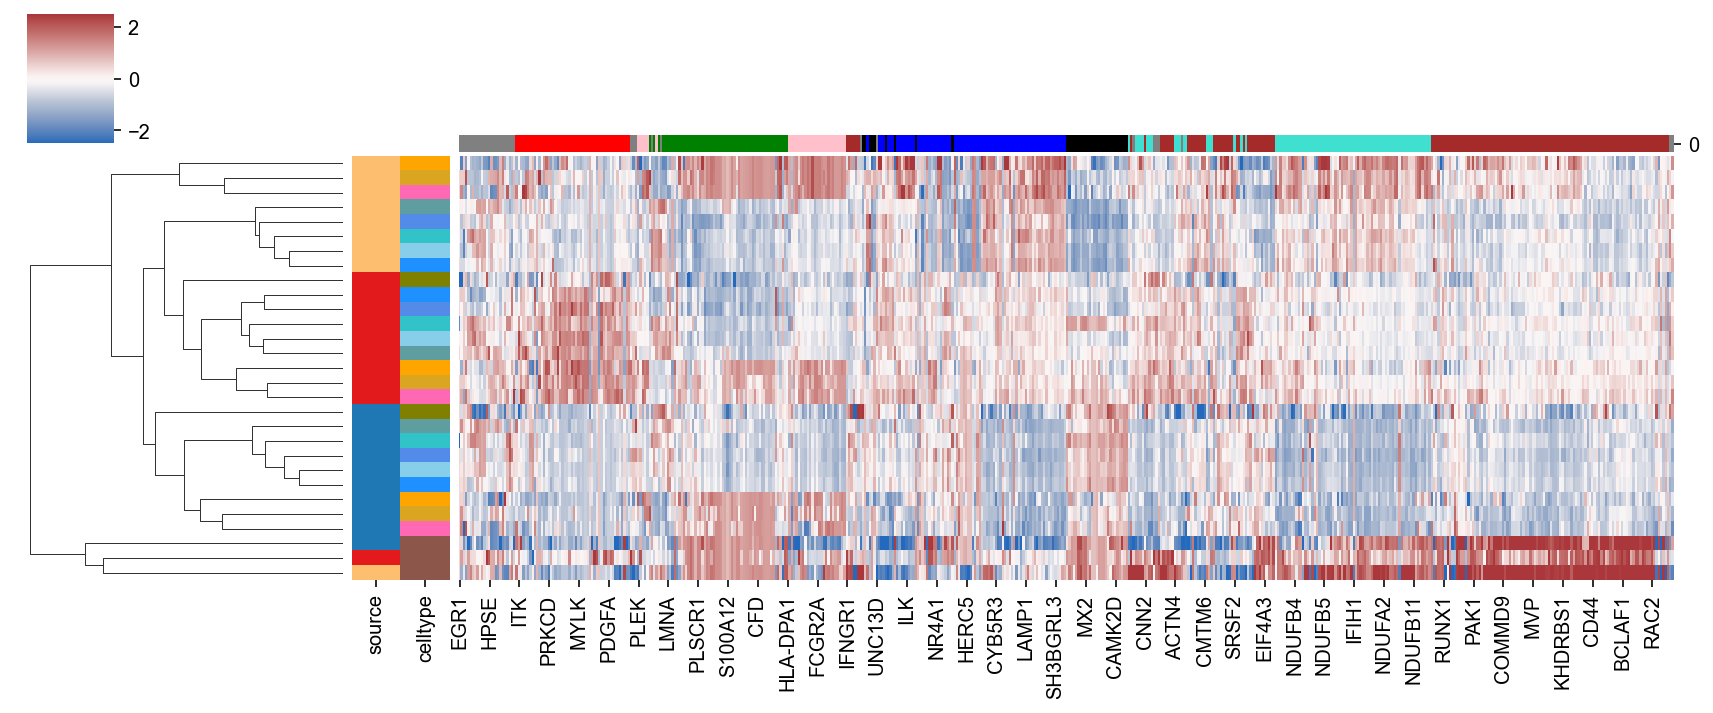

In [19]:
sns.clustermap(exp_WGCNA, row_cluster=True, col_cluster=False, figsize=(12, 5),
               z_score=1,standard_scale=None, cmap='vlag', yticklabels=False, col_colors=colors,vmin=-2.5,vmax=2.5, row_colors=col_colors)
plt.savefig('./figures/WGCNA.heatmap.pdf', dpi=600)

In [11]:
tmp= colors.copy()
tmp.columns = ['color']
tmp['genes'] = tmp.index
_dict = tmp.pivot(columns='color', values='genes').to_dict('list')
for k, v in _dict.items():
    _dict[k] = [ item for item in v if str(item)!='nan']

In [12]:
pd.DataFrame(dict([(k, pd.Series(v)) for k, v in _dict.items()])).to_csv('./output/WGCNA.gene_mudule.list.csv', sep=',', index=False)